In [12]:
import os
import dotenv

dotenv.load_dotenv()

def _set_env(var:str):
    if not os.environ.get(var):
        os.environ[var] = os.environ.get(var)

_set_env("TAVILY_API_KEY")


In [13]:
# tavily는 LLM모델을 RAG로 사용하기에 특화 된 검색 엔진
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'What Is LangGraph and How to Use It? - DataCamp',
  'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'To install LangGraph, you can use pip:\npip install -U langgraph\nBasic Concepts\nNodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as: [...] Imagine your application as a directed graph. In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed.\nState management',
  'score': 0.8400968443278085},
 {'title': 'A Comprehensive Guide About Langgraph: Code Included - Ionio',
  'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
  'content': 'Now let’s take a look at each component of langgraph in detail 🚀\nNodes\nA node can be any fun

In [14]:
len(tools)

1

LangGraph.ipynb에서 수행했던 기본 챗봇에 bind_tools를 이용해 tavily search를 추가한 챗봇을 만들어보자

bind_tools를 활용해 LLM이 어떤 검색 엔진을 사용해야 하는 지 인식하게 할 수 있음

In [15]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)


위에서 LLM이 어떤 검색 엔진을 사용하는 지 인식시켰으니 이제 실제로 해당 검색 엔진이 실행되었을 때, 실제로 검색 엔진이 호출되어 사용될 수 있도록 해줘야 함   

이런 걸 ToolNode에서 해결해주지만, LangGraph에서는 BasicToolNode를 구현해서 어떻게 동작되는지를 보여줌.

In [16]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    # 해당 노드는 요구된 마지막 AI메시지에서 툴을 실행
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # tools에 저장된 tool을 dictionary로 저장
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []): # 메시지가 있는지 확인
            message = messages[-1] # 마지막 메시지를 가져옴
        else:
            raise ValueError("No messages found in input")
        outputs = []

        for tool_call in message.tool_calls: # 메시지에 툴 호출이 있는지 확인
            # 툴 호출이 있으면 툴 호출을 실행
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                ) # 툴의 결과를 tool message로 변환환
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

edges는 한 node에서 다음 node로 제어 흐름을 라우팅함. Conditional edges는 현재 graph state에서 다른 노드의 의존성을 라우팅하기 위해 if statements을 포함한다.
해당 함수는 현재 graph state를 받고 node가 다음 node를 가르키는 string또는 list의 strings을 반환한다.

call은 route_tools로 불리는 router function으로 정의된다. route_tools는 챗봇의 결과에서 tool_calls를 체크한다.   
챗봇 node가 다음 node로 진행되어도 상관없는지 확인하는 add_conditional_edges함수를 제공한다.

In [17]:
def route_tools(
        state: State,
):
    """
    만약 마지막 메시지가 tool_calls를 포함하고 있다면, 툴 노드로 라우팅하기 위해 conditional edge를 사용
    만약 마지막 메시지가 tool_calls를 포함하고 있지 않다면, end를 라우팅
    """
    if isinstance(state, list):
        ai_message = state[-1] # state가 list인 경우 마지막 메시지를 가져옴
    elif messages := state.get("messages", []):
        ai_message = messages[-1] # state가 dict인 경우 messages의 마지막 메시지를 가져옴
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    print(f"ai_message: {ai_message}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools" # 마지막 메시지가 tool_calls를 포함하고 있으면 tools node로 라우팅
    return END

# 챗봇이 tool을 사용하는 걸 요청하면, tools_conditional 함수는 tools를 리턴하고 나서 END를 리턴함
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {'tools': "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

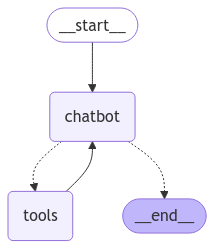

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

ai_message: content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 80, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'id': 'chatcmpl-BDPxeDM3KPhSFJio85jEi6L3DJyXB', 'finish_reason': 'stop', 'logprobs': None} id='run-729434ed-f945-4699-bdd0-bf97218019ff-0' usage_metadata={'input_tokens': 80, 'output_tokens': 11, 'total_tokens': 91, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Assistant: Hello! How can I assist you today?
ai_message: content='' additional_kwargs={'tool_calls': [{'id': 'call_pda4O8sTjefdAKcMTjjS8Ymx', 'function': {'arguments': '{"query":"LangGraph"}', 'na